### 1.
Importing data and splitting into test, validation and training data.

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15
SEED = 42
DTYPE = np.float32

#-------------------------------------------------------- Utils --------------------------------------------------#
def fit_minmax(X):
    """Fit per-feature min-max on X (2D). Returns (mins, ranges) with safe ranges."""
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = maxs - mins
    rng_safe = np.where(rng > 0, rng, 1.0)  # avoid division by zero for constant features
    return mins, rng_safe

def transform_minmax(X, mins, rng_safe):
    return (X - mins) / rng_safe

def inverse_minmax(X_scaled, mins, rng_safe):
    return X_scaled * rng_safe + mins

def split_by_groups(groups, train_frac, val_frac, test_frac, seed=42):
    """
    Split indices by unique group IDs (e.g., df row index). All samples from a group
    go to the same split. Returns boolean masks for train/val/test of length len(groups).
    """
    assert abs((train_frac + val_frac + test_frac) - 1.0) < 1e-8, "Fractions must sum to 1."
    rng = np.random.default_rng(seed)
    unique_groups = np.unique(groups)
    rng.shuffle(unique_groups)

    n = len(unique_groups)
    n_train = int(round(train_frac * n))
    n_val = int(round(val_frac * n))
    # assign the remainder to test to guarantee coverage of all groups
    n_test = n - n_train - n_val

    train_groups = set(unique_groups[:n_train])
    val_groups   = set(unique_groups[n_train:n_train + n_val])
    test_groups  = set(unique_groups[n_train + n_val:])

    train_mask = np.array([g in train_groups for g in groups], dtype=bool)
    val_mask   = np.array([g in val_groups for g in groups], dtype=bool)
    test_mask  = np.array([g in test_groups for g in groups], dtype=bool)

    return train_mask, val_mask, test_mask
#-----------------------------------------------------------------------------------------------------------------#

filename = 'sz.csv'
df = pd.read_csv(os.path.join("Input", filename))
input_list = []
output_list = []
group_ids = []  # keep the df row index for group-aware splitting

for idx, row in df.iterrows():
    # Inputs
    dV_ges = float(row["dV_ges"]) / 3.6 * 1e-6
    eps_0 = float(row["eps_0"])
    phi_0 = float(row["phi_0"])
    h_dis_0 = float(row["h_dis_0"])
    h_c_0 = float(row["h_c_0"])
    rho_c = float(row["rho_c"])
    rho_d = float(row["rho_d"])
    eta_c = float(row["eta_c"])
    eta_d = float(row["etc_d"])
    sigma = float(row["sigma"])
    T = float(row["T"])
    r_s_star = float(row["r_S_star"])
    h_p_star = float(row["h_p_star"])
    DPZ_pos = np.fromstring(row['DPZ_pos_ivgu'].strip("[]"), sep=",") / 100
    # Outputs
    DPZ_height = np.fromstring(row['DPZ_height_ivgu'].strip("[]"), sep=",") / 1000
    DPZ_bot = np.fromstring(row['DPZ_bot_ivgu'].strip("[]"), sep=",") / 1000
    # Build a mask where all arrays are not NaN at the same index
    mask = ~(np.isnan(DPZ_pos) | np.isnan(DPZ_height) | np.isnan(DPZ_bot))
    DPZ_pos = DPZ_pos[mask]
    DPZ_height = DPZ_height[mask]
    DPZ_bot = DPZ_bot[mask]
    lam = float(row["lambda"])

    for i in range(len(DPZ_pos)):
        inp = [dV_ges, eps_0, phi_0, h_dis_0, h_c_0, rho_c, rho_d, 
               eta_c, eta_d, sigma, T, r_s_star, h_p_star, DPZ_pos[i]]
        out = [lam, DPZ_height[i], DPZ_bot[i]]
        input_list.append(inp)
        output_list.append(out)
        group_ids.append(idx)  # same df row id for all generated points

X = np.array(input_list, dtype=np.float32)
Y = np.array(output_list, dtype=np.float32)
groups = np.array(group_ids)

print(f"Built arrays: X shape = {X.shape}, Y shape = {Y.shape}, unique groups = {len(np.unique(groups))}")


#-------------------------------------------------------- Splitting --------------------------------------------------#
train_mask, val_mask, test_mask = split_by_groups(groups, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=SEED)

X_train, Y_train = X[train_mask], Y[train_mask]
X_val,   Y_val   = X[val_mask],   Y[val_mask]
X_test,  Y_test  = X[test_mask],  Y[test_mask]

print("Split sizes (samples):",f"train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
#---------------------------------------------------------------------------------------------------------------------#


#---------------------------------- Normalization only on training dataset -------------------------------------------#
x_mins, x_rng = fit_minmax(X_train)
y_mins, y_rng = fit_minmax(Y_train)

X_train_n = transform_minmax(X_train, x_mins, x_rng)
X_val_n   = transform_minmax(X_val,   x_mins, x_rng)
X_test_n  = transform_minmax(X_test,  x_mins, x_rng)

Y_train_n = transform_minmax(Y_train, y_mins, y_rng)
Y_val_n   = transform_minmax(Y_val,   y_mins, y_rng)
Y_test_n  = transform_minmax(Y_test,  y_mins, y_rng)
# ---------------------------
# Convert to torch tensors
# ---------------------------
X_train_t = torch.from_numpy(X_train_n)
Y_train_t = torch.from_numpy(Y_train_n)
X_val_t   = torch.from_numpy(X_val_n)
Y_val_t   = torch.from_numpy(Y_val_n)
X_test_t  = torch.from_numpy(X_test_n)
Y_test_t  = torch.from_numpy(Y_test_n)

print("Torch tensors:", X_train_t.shape, Y_train_t.shape, X_val_t.shape, Y_val_t.shape, X_test_t.shape, Y_test_t.shape)
#---------------------------------------------------------------------------------------------------------------------#

Built arrays: X shape = (9404, 14), Y shape = (9404, 3), unique groups = 362
Split sizes (samples): train=6595, val=1415, test=1394
Torch tensors: torch.Size([6595, 14]) torch.Size([6595, 3]) torch.Size([1415, 14]) torch.Size([1415, 3]) torch.Size([1394, 14]) torch.Size([1394, 3])


In [1]:
import os
import numpy as np
import pandas as pd
import torch

def fit_minmax(X):
    """Fit per-feature min-max on X (2D). Returns (mins, ranges) with safe ranges."""
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = maxs - mins
    rng_safe = np.where(rng > 0, rng, 1.0)  # avoid division by zero (constant features)
    return mins.astype(DTYPE), rng_safe.astype(DTYPE)

def transform_minmax(X, mins, rng_safe):
    return ((X - mins) / rng_safe).astype(DTYPE)

def inverse_minmax(X_scaled, mins, rng_safe):
    return (X_scaled * rng_safe + mins).astype(DTYPE)

def split_dataframe_rows(df, train_frac, val_frac, test_frac, seed=42):
    """Split the *rows* of the original df into train/val/test by fraction."""
    assert abs((train_frac + val_frac + test_frac) - 1.0) < 1e-8, "Fractions must sum to 1."
    rng = np.random.default_rng(seed)
    idx = df.index.to_numpy()
    rng.shuffle(idx)

    n = len(idx)
    n_train = int(round(train_frac * n))
    n_val = int(round(val_frac * n))
    n_test = n - n_train - n_val

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]

    return df.loc[train_idx], df.loc[val_idx], df.loc[test_idx]


def expand_split(df_split):
    """
    Expand a split of the original df into (X, Y) arrays by iterating each row,
    parsing vector fields, masking NaNs per-row, and stacking all samples.
    """
    inputs, outputs = [], []

    for _, row in df_split.iterrows():
        # ---- scalar inputs (with the same preprocessing as in your pipeline) ----
        dV_ges   = float(row["dV_ges"]) / 3.6 * 1e-6
        eps_0    = float(row["eps_0"])
        phi_0    = float(row["phi_0"])
        h_dis_0  = float(row["h_dis_0"])
        h_c_0    = float(row["h_c_0"])
        rho_c    = float(row["rho_c"])
        rho_d    = float(row["rho_d"])
        eta_c    = float(row["eta_c"])
        eta_d    = float(row["etc_d"])
        sigma    = float(row["sigma"])
        T        = float(row["T"])
        r_s_star = float(row["r_S_star"])
        h_p_star = float(row["h_p_star"])
        lam      = float(row["lambda"])

        # ---- vector fields (convert units like before) ----
        DPZ_pos    = np.fromstring(str(row['DPZ_pos_ivgu']).strip("[]"), sep=",") / 100.0     # m
        DPZ_height = np.fromstring(str(row['DPZ_height_ivgu']).strip("[]"), sep=",") / 1000.0 # m
        DPZ_bot    = np.fromstring(str(row['DPZ_bot_ivgu']).strip("[]"), sep=",") / 1000.0   # m

        # ---- per-row NaN mask to keep only valid aligned entries ----
        mask = ~(np.isnan(DPZ_pos) | np.isnan(DPZ_height) | np.isnan(DPZ_bot))
        if not np.any(mask):
            continue  # skip row if nothing valid

        DPZ_pos_v    = DPZ_pos[mask]
        DPZ_height_v = DPZ_height[mask]
        DPZ_bot_v    = DPZ_bot[mask]

        # ---- expand: one sample per DPZ position ----
        const_feats = [dV_ges, eps_0, phi_0, h_dis_0, h_c_0, rho_c, rho_d,
                       eta_c, eta_d, sigma, T, r_s_star, h_p_star]
        for i in range(len(DPZ_pos_v)):
            x_vec = const_feats + [DPZ_pos_v[i]]
            y_vec = [lam, DPZ_height_v[i], DPZ_bot_v[i]]
            inputs.append(x_vec)
            outputs.append(y_vec)

    X = np.array(inputs, dtype=DTYPE)
    Y = np.array(outputs, dtype=DTYPE)
    return X, Y

In [2]:
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15
SEED = 42
DTYPE = np.float32
CSV_PATH = os.path.join("Input", "sz.csv")

# 1) Read original CSV
df = pd.read_csv(CSV_PATH)

# 2) Split by original rows (no expansion yet)
train_df, val_df, test_df = split_dataframe_rows(df, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=SEED)
print(f"Row splits: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

# 3) Expand each split separately (no cross-split leakage)
X_train, Y_train = expand_split(train_df)
X_val,   Y_val   = expand_split(val_df)
X_test,  Y_test  = expand_split(test_df)

print("Expanded sample counts:", f"train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
print("Feature/Target dims:", X_train.shape[1], Y_train.shape[1])

# 4) Fit Min–Max on TRAIN only; transform all splits
x_mins, x_rng = fit_minmax(X_train)
y_mins, y_rng = fit_minmax(Y_train)

X_train_n = transform_minmax(X_train, x_mins, x_rng)
X_val_n   = transform_minmax(X_val,   x_mins, x_rng)
X_test_n  = transform_minmax(X_test,  x_mins, x_rng)

Y_train_n = transform_minmax(Y_train, y_mins, y_rng)
Y_val_n   = transform_minmax(Y_val,   y_mins, y_rng)
Y_test_n  = transform_minmax(Y_test,  y_mins, y_rng)

# 5) Convert to torch tensors (ready for DataLoaders)
X_train_t = torch.from_numpy(X_train_n)
Y_train_t = torch.from_numpy(Y_train_n)
X_val_t   = torch.from_numpy(X_val_n)
Y_val_t   = torch.from_numpy(Y_val_n)
X_test_t  = torch.from_numpy(X_test_n)
Y_test_t  = torch.from_numpy(Y_test_n)

print("Torch tensors:",
      X_train_t.shape, Y_train_t.shape,
      X_val_t.shape,   Y_val_t.shape,
      X_test_t.shape,  Y_test_t.shape)

# Save normalization params for inference-time inverse-transform
np.savez(
    "minmax_params_corrected.npz",
    x_mins=x_mins, x_rng=x_rng,
    y_mins=y_mins, y_rng=y_rng
)

Row splits: train=253, val=54, test=55
Expanded sample counts: train=6595, val=1415, test=1394
Feature/Target dims: 14 3
Torch tensors: torch.Size([6595, 14]) torch.Size([6595, 3]) torch.Size([1415, 14]) torch.Size([1415, 3]) torch.Size([1394, 14]) torch.Size([1394, 3])


### 2. 
Code for saving normalized datasets and scalers. Also example of how to load test dataset, unnormalize it and evaluate in trained model.

In [2]:
# ---------------------------
# (Optional) Save artifacts for later use
# ---------------------------
# Save scaling parameters (so you can inverse-transform predictions later)
np.savez(
    "minmax_params.npz",
    x_mins=x_mins, x_rng=x_rng,
    y_mins=y_mins, y_rng=y_rng
)

# Save splits (numpy or torch—choose one). Here: numpy.
np.savez_compressed(
    "dataset_splits_minmax.npz",
    X_train=X_train_n, Y_train=Y_train_n,
    X_val=X_val_n,     Y_val=Y_val_n,
    X_test=X_test_n,   Y_test=Y_test_n,
    groups=groups
)

# Example inverse-transform for predictions later:
# with np.load("minmax_params.npz") as d:
#     y_mins, y_rng = d["y_mins"], d["y_rng"]
# y_pred = model(X_test_t).detach().cpu().numpy()
# y_pred_original_units = inverse_minmax(y_pred, y_mins, y_rng)

### 3.
Creating the model

In [3]:
from torch import nn
import math

class DNN(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, activation="silu", dropout=0.0):
        super().__init__()
        acts = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "silu": nn.SiLU,
            "tanh": nn.Tanh
        }
        if activation not in acts:
            raise ValueError(f"activation must be one of {list(acts.keys())}")
        Act = acts[activation]

        layers = []
        prev = in_dim
        for i, h in enumerate(hidden_dims):
            layers += [nn.Linear(prev, h), Act()]
            if dropout and dropout > 0:
                layers += [nn.Dropout(p=dropout)]
            prev = h
        # Linear output for regression
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

        # Weight init (He for ReLU/SiLU/GELU, Xavier for Tanh)
        for m in self.net:
            if isinstance(m, nn.Linear):
                if activation in ("relu", "silu", "gelu"):
                    nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                else:  # tanh
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        return self.net(x)
    
in_dim  = X_train_t.shape[1]
out_dim = Y_train_t.shape[1]
hidden  = [128, 128, 128]  # good starting point; try [128,128] if you want simpler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN(in_dim, hidden, out_dim, activation="silu", dropout=0.0).to(device)

### 4.
Train the model

In [6]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64
train_ds = TensorDataset(X_train_t, Y_train_t)
val_ds   = TensorDataset(X_val_t,   Y_val_t)
test_ds  = TensorDataset(X_test_t,  Y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.MSELoss()  # targets are scaled; MSE is fine
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=10, verbose=True
)

c:\Users\iagr9\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training loop

In [7]:
EPOCHS = 300
PATIENCE = 50
best_val = float("inf")
best_state = None
epochs_no_improve = 0
losses_history = []

for epoch in range(1, EPOCHS + 1):
    # train
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    lr = optimizer.param_groups[0]['lr']
    losses_history.append([train_loss, val_loss, lr])

    scheduler.step(val_loss)

    if val_loss < best_val - 1e-8:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch:03d} | train MSE: {train_loss:.6f} | val MSE: {val_loss:.6f} | LR: {lr:.2e}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch}. Best val MSE: {best_val:.6f}")
        break


# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 001 | train MSE: 0.002052 | val MSE: 0.003406 | LR: 3.00e-03
Epoch 002 | train MSE: 0.001976 | val MSE: 0.003209 | LR: 3.00e-03
Epoch 003 | train MSE: 0.001805 | val MSE: 0.003627 | LR: 3.00e-03
Epoch 004 | train MSE: 0.001846 | val MSE: 0.003233 | LR: 3.00e-03
Epoch 005 | train MSE: 0.001912 | val MSE: 0.003325 | LR: 3.00e-03
Epoch 006 | train MSE: 0.001815 | val MSE: 0.003280 | LR: 3.00e-03
Epoch 007 | train MSE: 0.001788 | val MSE: 0.004895 | LR: 3.00e-03
Epoch 008 | train MSE: 0.001789 | val MSE: 0.004135 | LR: 3.00e-03
Epoch 009 | train MSE: 0.001795 | val MSE: 0.003182 | LR: 3.00e-03
Epoch 010 | train MSE: 0.001750 | val MSE: 0.003257 | LR: 3.00e-03
Epoch 011 | train MSE: 0.001637 | val MSE: 0.003771 | LR: 3.00e-03
Epoch 012 | train MSE: 0.001744 | val MSE: 0.003650 | LR: 3.00e-03
Epoch 013 | train MSE: 0.001793 | val MSE: 0.003903 | LR: 3.00e-03
Epoch 014 | train MSE: 0.001632 | val MSE: 0.003709 | LR: 3.00e-03
Epoch 015 | train MSE: 0.001674 | val MSE: 0.003311 | LR: 3.00

Test the trained model

In [8]:
def evaluate_mse(loader):
    model.eval()
    mse = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            mse += nn.functional.mse_loss(pred, yb, reduction="sum").item()
    return mse / len(loader.dataset)

test_mse = evaluate_mse(test_loader)
print(f"Test MSE (scaled): {test_mse:.6f}")

Test MSE (scaled): 0.017979


See metrics in original units

In [ ]:
try:
    mm = np.load("minmax_params_corrected.npz")
    y_mins, y_rng = mm["y_mins"], mm["y_rng"]

    # Compute MAE/RMSE in original units
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)

    preds_u = inverse_minmax(preds, y_mins, y_rng)
    trues_u = inverse_minmax(trues, y_mins, y_rng)

    mae = np.mean(np.abs(preds_u - trues_u), axis=0)
    mape = 100 * mae
    rmse = np.sqrt(np.mean((preds_u - trues_u) ** 2, axis=0))
    print("Test MAE (original units) per target:", mae)
    print("Test MAPE (original units) per target:", mape, '%')
    print("Test RMSE (original units) per target:", rmse)
except FileNotFoundError:
    print("minmax_params.npz not found; skipping metrics in original units.")

Test MAE (original units) per target: [0.00091699 0.00367226 0.00178231]
Test MAPE (original units) per target: [0.09169862 0.36722565 0.1782309 ] %
Test RMSE (original units) per target: [0.00155602 0.00577832 0.00285016]


Save the model

In [10]:
torch.save(model.state_dict(), "dnn_2.pt")
print("Saved model to dnn_2.pt")

Saved model to dnn_2.pt


### 5.
See results

C:\Users\iagr9\AppData\Local\Temp\ipykernel_104552\3800467297.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dnn_1.pt"))


Predictions (10 rows, unnormalized/original units):
[[0.99287397 0.03805349 0.10114258]
 [0.99290425 0.03797169 0.10083118]
 [0.9929335  0.03741462 0.10047552]
 [0.9929566  0.03622846 0.10010925]
 [0.99296784 0.03427822 0.09977768]
 [0.99296284 0.03149965 0.09953292]
 [0.99293995 0.02796858 0.09942468]
 [0.99290204 0.02396763 0.09948894]
 [0.9928567  0.02001463 0.09973994]
 [0.99281484 0.01681774 0.10017047]]


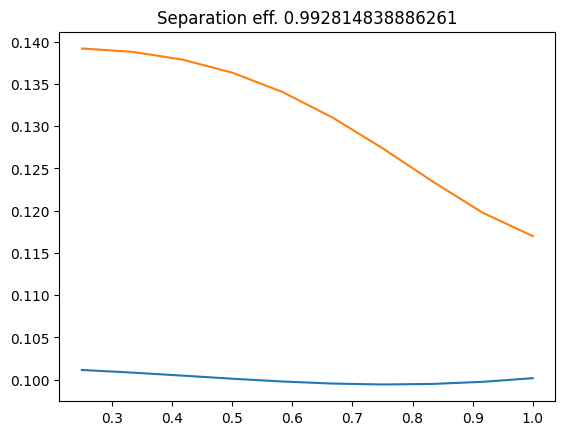

In [26]:
import matplotlib.pyplot as plt
# Load saved model if needed
hidden  = [128, 128, 128]  # good starting point; try [128,128] if you want simpler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_dim = 14
out_dim = 3
model = DNN(in_dim, hidden, out_dim, activation="silu", dropout=0.0).to(device)
model.load_state_dict(torch.load("dnn_1.pt"))
model.eval()  # set to evaluation mode


dV_ges    = 1007         # original units (as in CSV)
eps_0     = 0.4
phi_0     = 551e-6
h_dis_0   = 0.04
h_c_0     = 0.1
rho_c     = 1000
rho_d     = 825
eta_c     = 82e-5
eta_d     = 604e-5
sigma     = 0.00817
T         = 30
r_s_star  = 0.0085
h_p_star  = 0.2211
x_array   = np.linspace(0.25, 1.0, 10)  # DPZ_pos

# Apply the SAME transformations you used when building X in training:
# dV_ges -> /3.6 * 1e-6 ; DPZ_pos was in meters AFTER dividing by 100 in the CSV pipeline.
# Here, x_array is already in meters, so no extra /100.
dV_ges_tr = dV_ges / 3.6 * 1e-6

const_feats = np.array(
    [dV_ges_tr, eps_0, phi_0, h_dis_0, h_c_0,
     rho_c, rho_d, eta_c, eta_d, sigma, T, r_s_star, h_p_star],
    dtype=np.float32
)

# Stack 10 rows, each with the 13 constant features + the varying DPZ_pos
X_real = np.hstack([
    np.repeat(const_feats[None, :], repeats=len(x_array), axis=0),
    x_array.reshape(-1, 1).astype(np.float32)
])  # shape (10, 14)

assert X_real.shape[1] == in_dim, f"Expected {in_dim} features, got {X_real.shape[1]}."

X_scaled = transform_minmax(X_real, x_mins, x_rng)
X_t = torch.from_numpy(X_scaled).to(device)

with torch.no_grad():
    Y_scaled = model(X_t).cpu().numpy()

def transform_minmax(X, mins, rng):
    rng_safe = np.where(rng > 0, rng, 1.0)
    return (X - mins) / rng_safe

def inverse_minmax(Ys, mins, rng):
    return Ys * rng + mins

Y_pred = inverse_minmax(Y_scaled, y_mins, y_rng)  

print("Predictions (10 rows, unnormalized/original units):")
print(Y_pred)

plt.plot(x_array, Y_pred[:, 2])
plt.plot(x_array, Y_pred[:,1]+Y_pred[:,2], label='DPZ_top')
plt.title(f'Separation eff. {Y_pred[-1,0]}')
plt.show()